In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import math

from fuzzywuzzy import process
from highlight_text import ax_text
from PIL import Image
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from mplsoccer import FontManager, Sbopen, Pitch, VerticalPitch, add_image
pitch = Pitch(goal_type='box')

import warnings
pd.set_option('display.max_columns', None)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings(action="ignore", message="credentials were not supplied. open data access only")
warnings.filterwarnings('ignore', category=FutureWarning, module='seaborn')

### Data Preparation

In [2]:
parser = Sbopen()

competitions = parser.competition()
mls_2023 = competitions[(competitions.competition_name == "Major League Soccer") &
                        (competitions.season_name == "2023")]
mls_2023

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
61,44,107,United States of America,Major League Soccer,male,False,False,2023,2024-07-14T18:53:28.735163,2024-07-14T18:58:42.974543,2024-07-14T18:58:42.974543,2024-07-14T18:53:28.735163


In [3]:
games = pd.concat([parser.match(row.competition_id, row.season_id) for row in mls_2023.itertuples()])
games[["home_team_id", "home_team_name", "away_team_id", "away_team_name", "match_date", "home_score", "away_score"]]

,home_team_id,home_team_name,away_team_id,away_team_name,match_date,home_score,away_score
0,387,New York Red Bulls,1975,Inter Miami,2023-08-27,0,2
1,919,LAFC,1975,Inter Miami,2023-09-04,1,3
2,8070,Charlotte,1975,Inter Miami,2023-10-22,1,0
3,1975,Inter Miami,1938,Nashville SC,2023-08-31,0,0
4,1975,Inter Miami,489,Cincinnati,2023-10-08,0,1
5,1975,Inter Miami,575,Toronto FC,2023-09-21,4,0


In [4]:
match = games[(games.home_team_name == "Inter Miami") & (games.away_team_name == "Toronto FC")]
match_id = match.match_id.values[0]

events_df, related, freeze, tactics = parser.event(match_id)

In [5]:
def clean_player_id(x):
    if pd.isna(x):
        return None
    try:
        return float(x)
    except:
        return None
        
def fuzzy_short_name(raw_name):
    if pd.isna(raw_name):
        return None
    best_match = process.extractOne(raw_name, mls_players.long_name, score_cutoff=80)
    if best_match:
        matched_long_name = best_match[0]
        return name_mapping[matched_long_name]
    else:
        return raw_name

def fuzzy_image_path(raw_name):
    if pd.isna(raw_name):
        return None
    best_match = process.extractOne(raw_name, mls_players.long_name, score_cutoff=80)
    if best_match:
        matched_long_name = best_match[0]
        # find the row with that long_name
        matched_row = mls_players[mls_players['long_name'] == matched_long_name]
        if not matched_row.empty:
            return matched_row['local_image_path'].values[0]
    return None

In [6]:
unique_players = (events_df[['player_id','player_name']].dropna(subset=['player_id']).drop_duplicates(subset=['player_id']).copy())
mls_players = pd.read_csv('datasets/mls23_statsBomb_players.csv')
name_mapping = pd.Series(mls_players.short_name.values, index=mls_players.long_name).to_dict()

In [7]:
unique_players['short_name'] = unique_players['player_name'].apply(fuzzy_short_name)
unique_players['image_path'] = unique_players['player_name'].apply(fuzzy_image_path)

In [8]:
players_info = unique_players[['player_id','short_name','image_path']].copy()
events_df = pd.merge(events_df, players_info, on='player_id', how='left')
tactics = pd.merge(tactics, players_info, on='player_id', how='left')

#### Common features

In [9]:
def team_color(team, color='MainColor'):
    return df_teams_logo_color[df_teams_logo_color['Team'] == team][color].iloc[0]

def get_image(path, zoom=0.2):
    """Load an image from a path and return an OffsetImage."""
    try:
        return Image.open(path)
    except Exception as e:
        print(f"Error loading image {path}: {e}")
        return None

def team_logo(team_name):
    return get_image(df_teams_logo_color[df_teams_logo_color.Team == team_name]["Logo path"].iloc[0]) 

In [10]:
df_teams_logo_color = pd.read_csv('datasets/MLS_23_table.csv', usecols=['Team', 'Logo path', 'MainColor', 'SecondaryColor'])

In [12]:
events_df.columns

Index(['id', 'index', 'period', 'timestamp', 'minute', 'second', 'possession',
       'duration', 'match_id', 'type_id', 'type_name', 'possession_team_id',
       'possession_team_name', 'play_pattern_id', 'play_pattern_name',
       'team_id', 'team_name', 'tactics_formation', 'player_id', 'player_name',
       'position_id', 'position_name', 'pass_recipient_id',
       'pass_recipient_name', 'pass_length', 'pass_angle', 'pass_height_id',
       'pass_height_name', 'end_x', 'end_y', 'body_part_id', 'body_part_name',
       'sub_type_id', 'sub_type_name', 'x', 'y', 'under_pressure',
       'outcome_id', 'outcome_name', 'counterpress', 'off_camera',
       'technique_id', 'technique_name', 'aerial_won', 'shot_statsbomb_xg',
       'end_z', 'shot_first_time', 'goalkeeper_position_id',
       'goalkeeper_position_name', 'pass_cross', 'out', 'pass_switch',
       'pass_assisted_shot_id', 'pass_shot_assist', 'shot_key_pass_id',
       'pass_no_touch', 'substitution_replacement_id',
       '

In [13]:
events_df['type_name'].unique()

array(['Starting XI', 'Half Start', 'Pass', 'Ball Receipt', 'Carry',
       'Pressure', 'Foul Committed', 'Foul Won', 'Dispossessed', 'Duel',
       'Ball Recovery', 'Interception', 'Dribble', 'Clearance', 'Block',
       'Dribbled Past', 'Miscontrol', 'Error', 'Shot', 'Goal Keeper',
       'Substitution', '50/50', 'Injury Stoppage', 'Tactical Shift',
       'Referee Ball-Drop', 'Player Off', 'Player On', 'Half End'],
      dtype=object)

### Passes map

In [14]:
def unique_outcome(type_name):
    event = events_df.loc[(events_df['type_name'] == type_name), ['x', 'y', 'end_x', 'end_y', 'outcome_name']]
    failed_event = event[event.outcome_name.notna()]
    return failed_event["outcome_name"].unique()

In [15]:
unique_outcome('Pass')

array(['Incomplete', 'Out', 'Unknown', 'Pass Offside'], dtype=object)

In [16]:
def visualize_pass_network(actions, actions_name, player_name, successful_color='blue', unsuccessful_color='red'):
    complete_actions = actions.outcome_name.isnull()
    df_player_action = actions[actions["player_name"] == player_name]
    num_actions = len(df_player_action)

    fig, ax = pitch.draw(figsize=(12, 7), constrained_layout=True, tight_layout=False)
    
    # Plot successful actions
    pitch.arrows(df_player_action[complete_actions].x, df_player_action[complete_actions].y,
                 df_player_action[complete_actions].end_x, df_player_action[complete_actions].end_y,
                 width=1, headwidth=5, headlength=4, color=successful_color, ax=ax, label='Successful')

    # Plot unsuccessful actions
    pitch.arrows(df_player_action[~complete_actions].x, df_player_action[~complete_actions].y,
                 df_player_action[~complete_actions].end_x, df_player_action[~complete_actions].end_y,
                 width=1, headwidth=5, headlength=4, color=unsuccessful_color, ax=ax, label='Unsuccessful')

    ax.legend(handlelength=3, edgecolor='None', fontsize=12, loc='upper center', bbox_to_anchor=(0.5, 0.06), ncol=2)
    ax.set_title(f'{num_actions} {actions_name} by {player_name}', fontsize=17, pad=2)

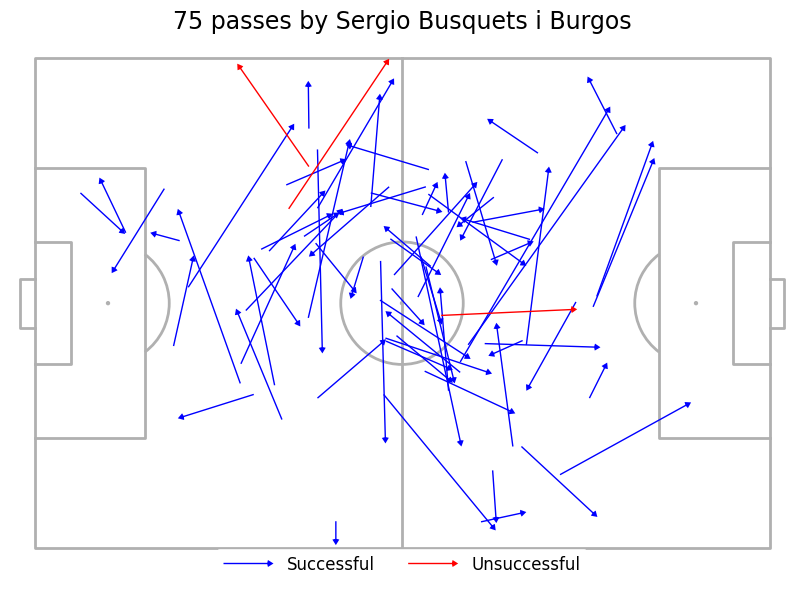

In [17]:
visualize_pass_network(events_df[events_df['type_name'] == 'Pass'], 'passes', 'Sergio Busquets i Burgos')

### Carry map

In [18]:
def visualize_carry_network(actions, actions_name, player_name, color='blue'):
    df_player_action = actions[actions["player_name"] == player_name]
    num_actions = len(df_player_action)

    fig, ax = pitch.draw(figsize=(12, 7), constrained_layout=True, tight_layout=False)

    pitch.arrows(df_player_action.x, df_player_action.y,
                 df_player_action.end_x, df_player_action.end_y,
                 width=1, headwidth=5, headlength=4, color=color, ax=ax, label=actions_name)

    ax.legend(handlelength=5, edgecolor='None', fontsize=15, loc='upper center', bbox_to_anchor=(0.5, 0.06), ncol=1)
    ax.set_title(f'{num_actions} {actions_name} by {player_name}', fontsize=17, pad=2)

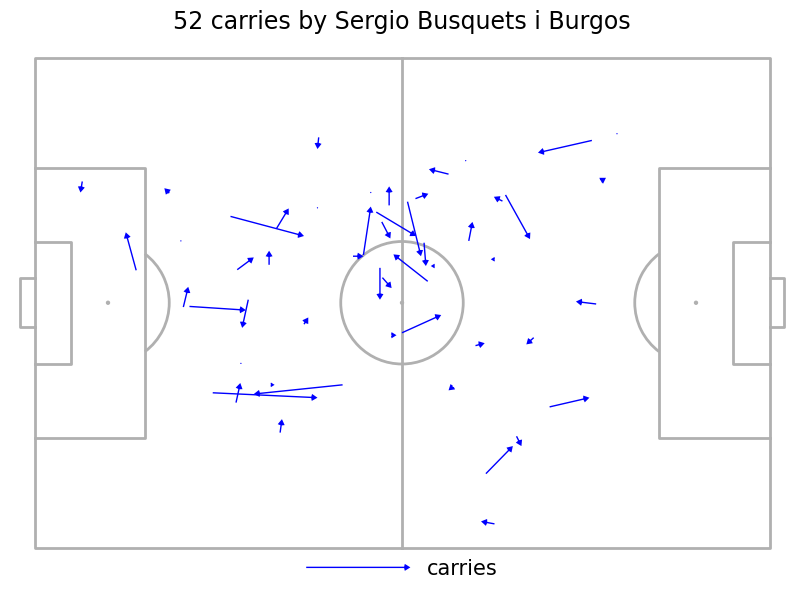

In [19]:
visualize_carry_network(events_df[events_df['type_name'] == 'Carry'], 'carries', 'Sergio Busquets i Burgos')

### Shot map

In [20]:
shots = events_df[events_df['type_name'] == 'Shot'][['team_name', 'player_name', 'x', 'y', 'end_x', 'end_y', 'under_pressure', 'outcome_name', 'technique_name', 'shot_statsbomb_xg', 'shot_one_on_one']]
shots.sort_values('shot_statsbomb_xg', ascending=False)

,team_name,player_name,x,y,end_x,end_y,under_pressure,outcome_name,technique_name,shot_statsbomb_xg,shot_one_on_one
605,Toronto FC,Deandre Kerr,108.0,32.5,117.1,38.2,NaN,Saved,Normal,0.298606,True
1159,Inter Miami,Lionel Andrés Messi Cuccittini,114.8,46.6,120.0,36.2,NaN,Off T,Volley,0.160210,NaN
214,Inter Miami,Josef Alexander Martínez Mencia,103.6,37.4,120.0,33.6,1.0,Off T,Normal,0.147720,NaN
3197,Inter Miami,Benjamin Cremaschi,111.5,52.3,120.0,36.7,NaN,Goal,Normal,0.136740,NaN
2228,Toronto FC,Lorenzo Insigne,106.8,40.2,117.9,39.7,NaN,Saved,Normal,0.128371,NaN
608,Toronto FC,Deandre Kerr,114.5,30.5,120.0,44.0,NaN,Post,Volley,0.109547,NaN
2097,Toronto FC,Lorenzo Insigne,99.9,38.5,120.0,46.7,NaN,Off T,Normal,0.083594,NaN
1865,Inter Miami,Facundo Farías,107.8,44.0,120.0,43.3,NaN,Goal,Volley,0.076869,NaN
2459,Inter Miami,Robert Taylor,101.1,51.0,120.0,36.6,NaN,Goal,Normal,0.076539,NaN
1061,Inter Miami,Lionel Andrés Messi Cuccittini,105.9,41.3,107.9,41.4,NaN,Blocked,Normal,0.073401,NaN


In [21]:
goals = shots[shots['outcome_name'] == 'Goal']
goals

,team_name,player_name,x,y,end_x,end_y,under_pressure,outcome_name,technique_name,shot_statsbomb_xg,shot_one_on_one
1865,Inter Miami,Facundo Farías,107.8,44.0,120.0,43.3,NaN,Goal,Volley,0.076869,NaN
2459,Inter Miami,Robert Taylor,101.1,51.0,120.0,36.6,NaN,Goal,Normal,0.076539,NaN
3197,Inter Miami,Benjamin Cremaschi,111.5,52.3,120.0,36.7,NaN,Goal,Normal,0.136740,NaN
3942,Inter Miami,Robert Taylor,113.9,52.9,120.0,40.4,1.0,Goal,Half Volley,0.072968,True


In [22]:
def plot_team_shots(pitch, ax, shots, team_name, marker_color, edge_color):
    team_shots = shots[shots.team_name == team_name].copy()
    
    # Mirror the x coordinates for the second team
    if team_name == shots.team_name.unique()[1]:
        team_shots['x'] = pitch.dim.right - team_shots['x']
        team_shots['end_x'] = pitch.dim.right - team_shots['end_x']

    # Non-goals
    pitch.scatter(team_shots[team_shots.outcome_name != 'Goal'].x, team_shots[team_shots.outcome_name != 'Goal'].y,
                  s=team_shots[team_shots.outcome_name != 'Goal'].shot_statsbomb_xg * 700,
                  edgecolors=edge_color, facecolors='none', linewidth=1, label='_nolegend_', ax=ax)
    # Goals
    pitch.scatter(team_shots[team_shots.outcome_name == 'Goal'].x, team_shots[team_shots.outcome_name == 'Goal'].y,
                  s=team_shots[team_shots.outcome_name == 'Goal'].shot_statsbomb_xg * 700,
                  c=marker_color, edgecolors=edge_color, linewidth=1, label='_nolegend_', ax=ax)

def visualize_teams_shot_map(shots):
    fig, ax = pitch.draw(figsize=(12, 7), constrained_layout=True, tight_layout=False)
    team1, team2 = shots.team_name.unique()
    
    plot_team_shots(pitch, ax, shots, team1, 'blue', 'blue')
    plot_team_shots(pitch, ax, shots, team2, 'red', 'red')
    
    plt.scatter([], [], c='none', edgecolors='gray', linewidth=1, s=100, label='Shot')
    plt.scatter([], [], c='gray', edgecolors='gray', linewidth=1, s=100, label='Goal')

    plt.scatter([], [], s=100, edgecolors='gray', facecolors='none', linewidth=1, label='Low xG')
    plt.scatter([], [], s=500, edgecolors='gray', facecolors='none', linewidth=1, label='High xG')

    handles, labels = ax.get_legend_handles_labels()
    unique_handles, unique_labels = [], []
    for handle, label in zip(handles, labels):
        if label not in unique_labels:
            unique_handles.append(handle)
            unique_labels.append(label)
    
    ax.legend(unique_handles, unique_labels, handlelength=5, edgecolor='None', fontsize=12, loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=4, handletextpad=-1.5)
    ax.set_title(f'Shot Map: {team1} vs {team2}', fontsize=17, pad=2)

    ax.text(0.85, 0.08, f'{team1} Shots', color='blue', fontsize=12, ha='center', va='center', transform=ax.transAxes)
    ax.text(0.15, 0.08, f'{team2} Shots', color='red', fontsize=12, ha='center', va='center', transform=ax.transAxes)

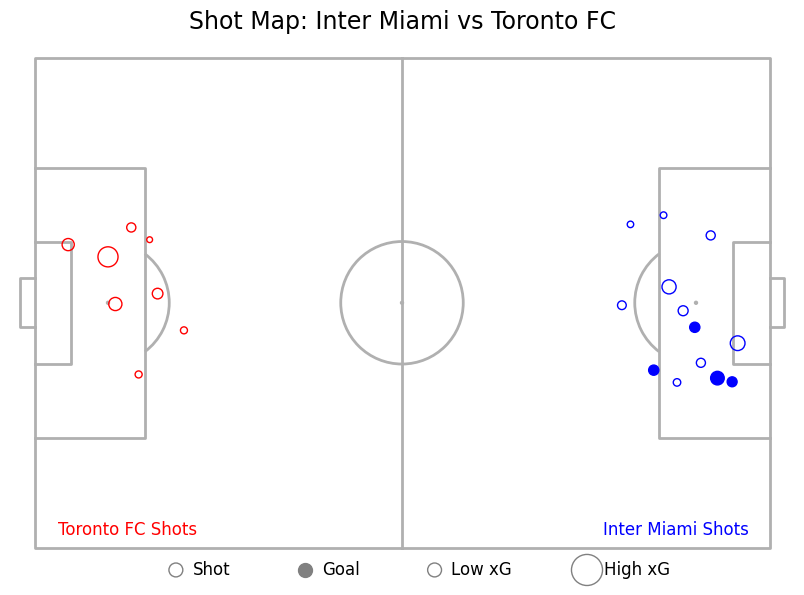

In [23]:
visualize_teams_shot_map(shots)

### Shot freeze frame

In [24]:
def visualize_goal_freeze_frame(match_id):
    parser = Sbopen()
    events_df, related, freeze, tactics = parser.event(match_id)
    lineup = parser.lineup(match_id)
    lineup = lineup[['player_id', 'jersey_number', 'team_name']].copy()
    # Goals
    goals = events_df[(events_df['type_name'] == 'Shot') & (events_df['outcome_name'] == 'Goal')]
    num_goals = len(goals)
    cols = 2
    rows = math.ceil(num_goals / cols)

    pitch = VerticalPitch(half=True, goal_type='box', pad_bottom=-20)
    fig, axs = pitch.grid(nrows=rows, ncols=cols, figheight=15,
                          endnote_height=0.03, endnote_space=0,
                          axis=False,
                          title_height=0.08, grid_height=0.84)
    robotto_regular = FontManager()

    for i, (ax, (_, goal_event)) in enumerate(zip(axs['pitch'].flat, goals.iterrows())):
        SHOT_ID = goal_event['id']
        freeze_frame = freeze[freeze.id == SHOT_ID].copy()
        shot_event = events_df[events_df.id == SHOT_ID].dropna(axis=1, how='all').copy()

        # Jersey number
        freeze_frame = freeze_frame.merge(lineup, how='left', on='player_id')
        team1 = shot_event.team_name.iloc[0]
        team2 = list(set(events_df.team_name.unique()) - {team1})[0]

        # Subset the team shooting, and the opposition (goalkeeper/other)
        df_team1 = freeze_frame[freeze_frame.team_name == team1]
        df_team2_goal = freeze_frame[(freeze_frame.team_name == team2) &
                                     (freeze_frame.position_name == 'Goalkeeper')]
        df_team2_other = freeze_frame[(freeze_frame.team_name == team2) &
                                      (freeze_frame.position_name != 'Goalkeeper')]

        # Players
        pitch.scatter(df_team1.x, df_team1.y, s=600, c='#727cce', label='Attacker', ax=ax)
        pitch.scatter(df_team2_other.x, df_team2_other.y, s=600,
                      c='#5ba965', label='Defender', ax=ax)
        pitch.scatter(df_team2_goal.x, df_team2_goal.y, s=600,
                      ax=ax, c='#c15ca5', label='Goalkeeper')

        # Shot
        pitch.scatter(shot_event.x, shot_event.y, marker='football',
                      s=600, ax=ax, label='Shooter', zorder=1.2)
        pitch.lines(shot_event.x, shot_event.y,
                    shot_event.end_x, shot_event.end_y, comet=True,
                    label='shot', color='#cb5a4c', ax=ax)

        # Angle to the goal
        pitch.goal_angle(shot_event.x, shot_event.y, ax=ax, alpha=0.2, zorder=1.1,
                         color='#cb5a4c', goal='right')
        
        # Jersey numbers
        for j, label in enumerate(freeze_frame.jersey_number):
            pitch.annotate(label, (freeze_frame.x[j], freeze_frame.y[j]),
                           va='center', ha='center', color='white',
                           fontproperties=robotto_regular.prop, fontsize=15, ax=ax)

        annotation_string = (f'{shot_event.minute.iloc[0]}\' '
                             f'<{shot_event.player_name.iloc[0]}> | '
                             f'{shot_event.shot_statsbomb_xg.iloc[0]:.2f} xG')
        ax_text(1, 121, annotation_string, ha='left', va='center', fontsize=13,
                      fontproperties=robotto_regular.prop,
                      highlight_textprops=[{"color": '#56ae6c'}], ax=ax)

    team1, team2 = events_df.team_name.unique()

    axs['title'].text(0.5, 0.65, f'{team1} vs {team2}', fontsize=40,
                      fontproperties=robotto_regular.prop, va='center', ha='center')
    SUB_TEXT = ('Shot Freeze Frames of match goals')
    axs['title'].text(0.5, 0.35, SUB_TEXT, fontsize=20,
                      fontproperties=robotto_regular.prop, va='center', ha='center')

    ax_team1_logo = add_image(team_logo(team1), fig,
                          left=axs['title'].get_position().x0,
                          bottom=axs['title'].get_position().y0,
                          height=axs['title'].get_position().height)
    ax_team2_logo = add_image(team_logo(team2), fig, left=0.9,
                              bottom=axs['title'].get_position().y0,
                              height=axs['title'].get_position().height)
    
    handles, labels = axs['pitch'][0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=5, fontsize=12, bbox_to_anchor=(0.5, 0.92))

    plt.tight_layout()
    plt.show()

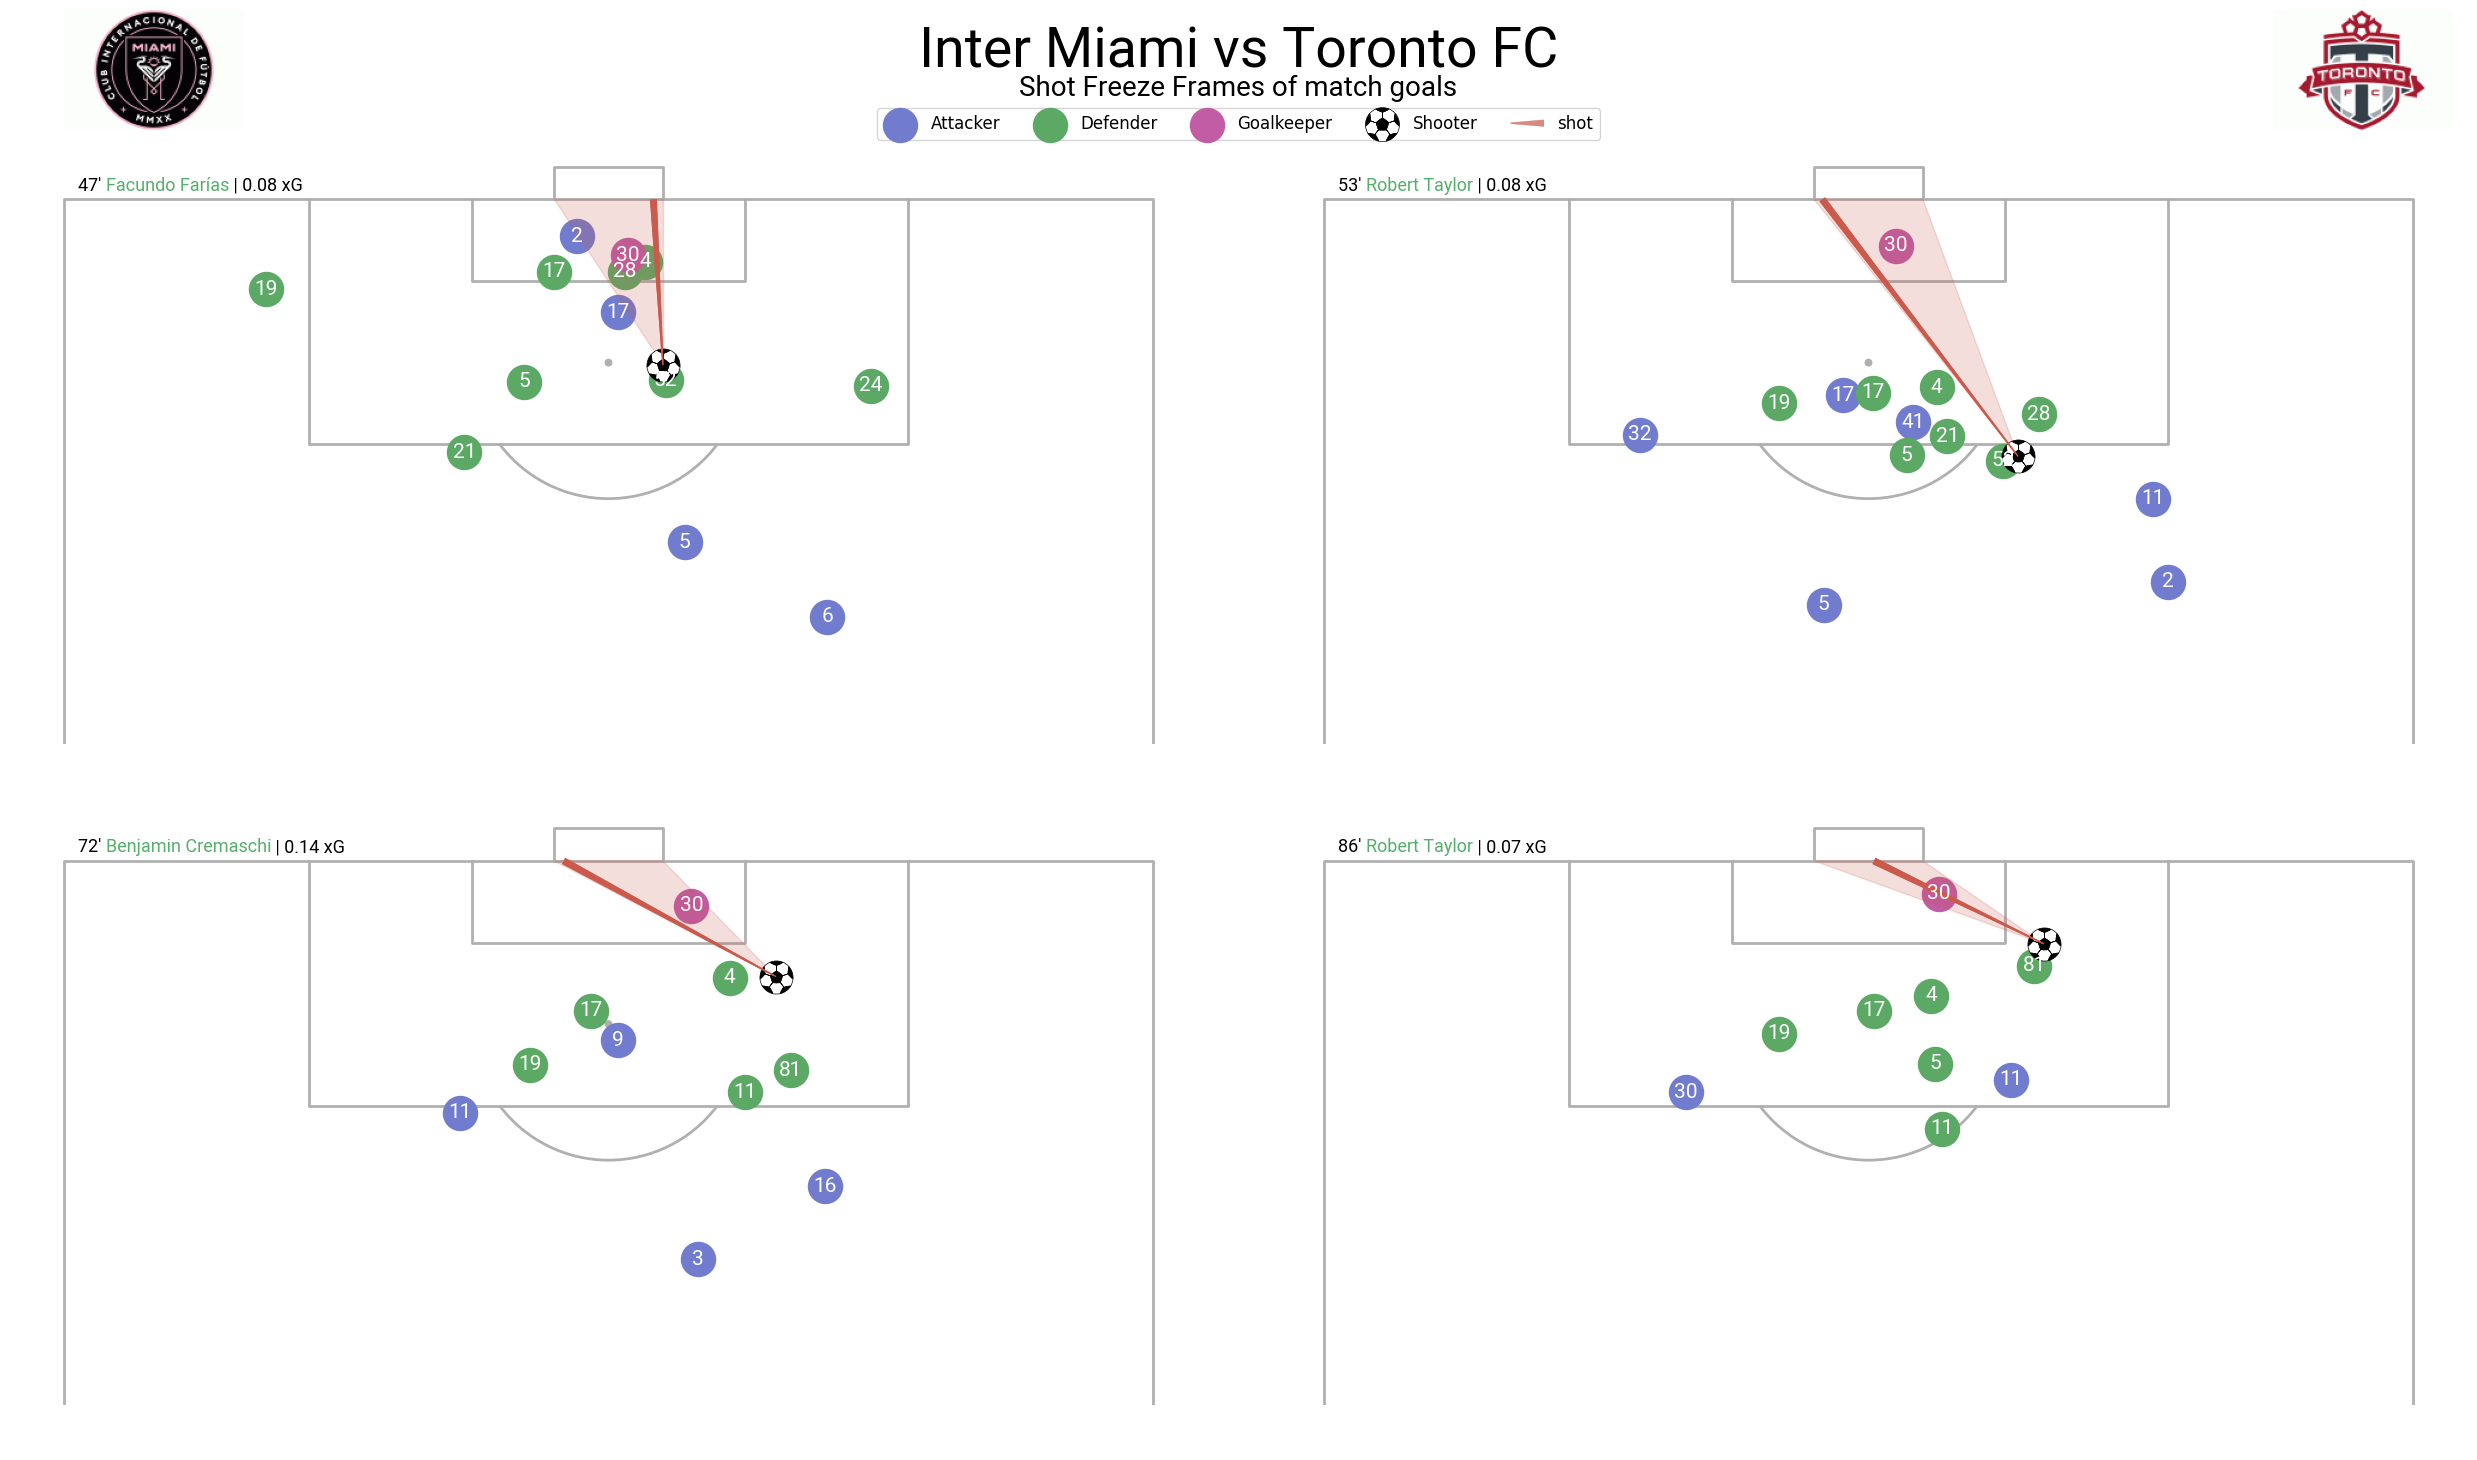

In [25]:
visualize_goal_freeze_frame(match_id)

### Heatmap

In [26]:
def plot_player_heatmap(events, player_name):
    player_events = events[events['player_name'] == player_name]
    
    touch_events = player_events[
        (player_events.type_name.isin(['Carry', 'Shot', 'Clearance', 'Foul Won'])) |
        ((player_events.type_name != 'Dribble') & (player_events.outcome_name == 'Complete')) |
        ((player_events.type_name == 'Pass') & (player_events.outcome_name.isnull()))|
        ((player_events.type_name == 'Ball Receipt') & (player_events.outcome_name.isnull()))
    ]
    
    pitch = Pitch(goal_type='box', line_zorder=2)
    fig, ax = pitch.draw(figsize=(12, 7))

    kde = sns.kdeplot(x=touch_events['x'], y=touch_events['y'], fill=True, cmap='rocket_r', bw_adjust=.5, ax=ax, levels=100, zorder=1, alpha=0.6)

    total_touches = len(touch_events)
    ax.text(60, -6, f'{player_name} Touches', fontsize=17, ha='center', color='black')
    ax.text(60, -2, f'Total Touches: {total_touches}', fontsize=13, ha='center', color='black', fontstyle='italic')

    sm = plt.cm.ScalarMappable(cmap='rocket_r')
    cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', pad=0.01, shrink=0.11, aspect=5)
    cbar.ax.tick_params(size=0, labelsize=0)
    cbar.set_ticks([])
    cbar.outline.set_visible(False)
    cbar.ax.text(-0.3, 0.5, 'Fewer\ntouches', ha='center', va='center', color='grey', transform=cbar.ax.transAxes, fontsize=10)
    cbar.ax.text(1.3, 0.5, 'More\ntouches', ha='center', va='center', color='grey', transform=cbar.ax.transAxes, fontsize=10)
    
    plt.setp(plt.getp(cbar.ax.axes, 'xticklabels'), color='black')

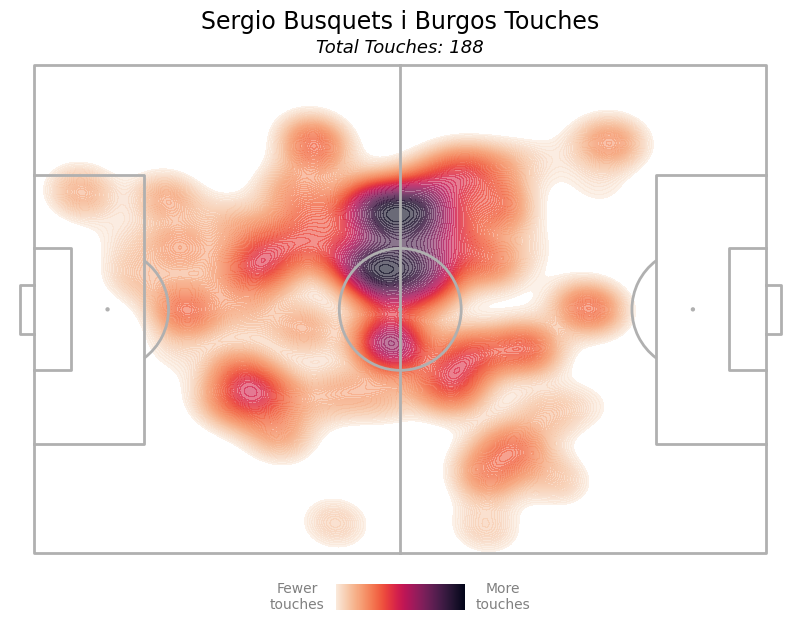

In [27]:
plot_player_heatmap(events_df, 'Sergio Busquets i Burgos')

### Formation

In [28]:
def get_starting_xi(event, tactics):
    teams = events_df['team_name'].unique()
    
    list_of_xi = []
    for t in teams:
        xi_one_team = tactics.merge(
            events_df.loc[
                (events_df['type_name'] == 'Starting XI') & 
                (events_df['team_name'] == t)
            ][['id','tactics_formation','team_name']],
            on='id',
            how='inner'
        )
        list_of_xi.append(xi_one_team)
    
    return pd.concat(list_of_xi, ignore_index=True)

In [29]:
starting_xi = get_starting_xi(events_df, tactics)

In [30]:
# Function to get team color
def team_color(team, color='MainColor'):
    return df_teams_logo_color[df_teams_logo_color['Team'] == team][color].iloc[0]

# Adapt the pitch.formations_dataframe to vertical orientation by swapping coords.
def create_custom_formation_df(pitch):
    custom_formation_df = pitch.formations_dataframe.copy()
    custom_formation_df['x_half'], custom_formation_df['y_half'] = (
        custom_formation_df['y_half'], custom_formation_df['x_half']
    )
    custom_formation_df['x_half_flip'], custom_formation_df['y_half_flip'] = (
        custom_formation_df['y_half_flip'], custom_formation_df['x_half_flip']
    )
    return custom_formation_df

# Return recommended zoom, x_offset, y_offset for vertical vs. horizontal pitch usage.
def get_pitch_offsets(pitch):
    if isinstance(pitch, VerticalPitch):
        return dict(zoom=0.80, x_offset=-5, y_offset=0)
    else:
        return dict(zoom=0.83, x_offset=0, y_offset=5)

# Function to plot team with text and scatter markers
def plot_team(team_xi, team, flip=False, pitch=None, ax=None):
    formation = team_xi['tactics_formation'].iloc[0]

    pitch.formation(formation, positions=team_xi['position_id'].values, kind='text',
                    text=team_xi['short_name'].values, xoffset=+3,
                    flip=flip, half=True, va='center', ha='center', fontsize=9, color='black', ax=ax)
    
    mpl.rcParams['hatch.linewidth'] = 2
    mpl.rcParams['hatch.color'] = team_color(team, 'MainColor')
    pitch.formation(formation, positions=team_xi['position_id'].values, kind='scatter',
                    c=team_color(team, 'SecondaryColor'), hatch='||', linewidth=1.5, 
                    s=300, flip=flip, half=True, xoffset=0, ax=ax)
    
# Function to plot team with player images
def plot_team_with_images(team_xi, flip=False, formation_df=None, pitch=None, ax=None):
    formation = team_xi['tactics_formation'].iloc[0]

    if isinstance(pitch, VerticalPitch):
        formation_df = create_custom_formation_df(pitch)
        formation_df = formation_df[formation_df['formation'] == formation]
    else:
        formation_df = pitch.formations_dataframe[pitch.formations_dataframe['formation'] == formation]

    cfg = get_pitch_offsets(pitch)
    zoom = cfg['zoom']
    x_offset = cfg['x_offset']
    y_offset = cfg['y_offset']
    
    pitch.formation(formation, positions=team_xi['position_id'].values, kind='text',
                    text=team_xi['short_name'].values, xoffset=x_offset,
                    yoffset=y_offset if 'y_offset' in locals() else None,
                    flip=flip, half=True, va='center', ha='center', fontsize=9, color='black', ax=ax)

    for _, row in team_xi.iterrows():
        img_path = row['image_path']
        position_id = row['position_id']
        if not img_path or pd.isna(img_path):
            img_path = "plotly-dash/assets/footballer.png"
        
        coords_row = formation_df[formation_df['statsbomb'].apply(lambda x: position_id in x)]
        img = plt.imread(img_path)
        if coords_row.empty:
            print(f"Position ID {pos_id} not found in formation DataFrame.")
            continue
            
        x, y = coords_row[['x_half', 'y_half']].values[0]
        if flip:
            x, y = coords_row[['x_half_flip', 'y_half_flip']].values[0]
        
        imagebox = OffsetImage(img, zoom=zoom)
        if isinstance(pitch, VerticalPitch): y += 1
        ab = AnnotationBbox(imagebox, (x, y), frameon=False, box_alignment=(0.5, 0.5))
        ax.add_artist(ab)

def plot_formation(df_xi, with_images=False, vertical=False):
    teams = df_xi['team_name'].unique()
    if vertical:
        pitch = VerticalPitch(line_alpha=0.5, goal_type='box', goal_alpha=0.5)
        figsize = (11, 8) if with_images else (7, 8)
    else:
        pitch = Pitch(line_alpha=0.5, goal_type='box', goal_alpha=0.5)
        figsize = (11, 8) if with_images else (7, 8)

    fig, ax = pitch.draw(figsize=figsize)
    for i, team in enumerate(teams):
        team_xi = df_xi[df_xi['team_name'] == team]
        
        if with_images:
            plot_team_with_images(team_xi, pitch=pitch, flip=bool(i), ax=ax)
        else:
            plot_team(team_xi, team, pitch=pitch, flip=bool(i), ax=ax)

    plt.title(f'{teams[0]} vs {teams[1]} Starting XI', fontsize=20)
    plt.tight_layout()
    plt.show()

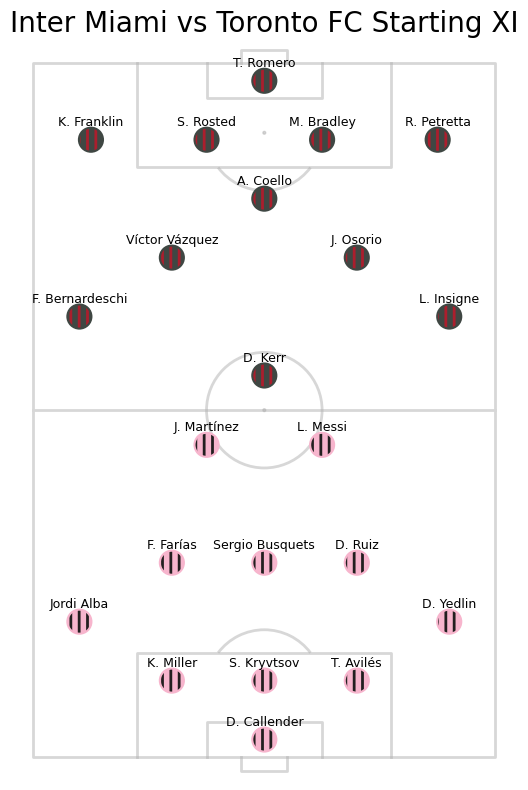

In [31]:
plot_formation(starting_xi, with_images=False, vertical=True)

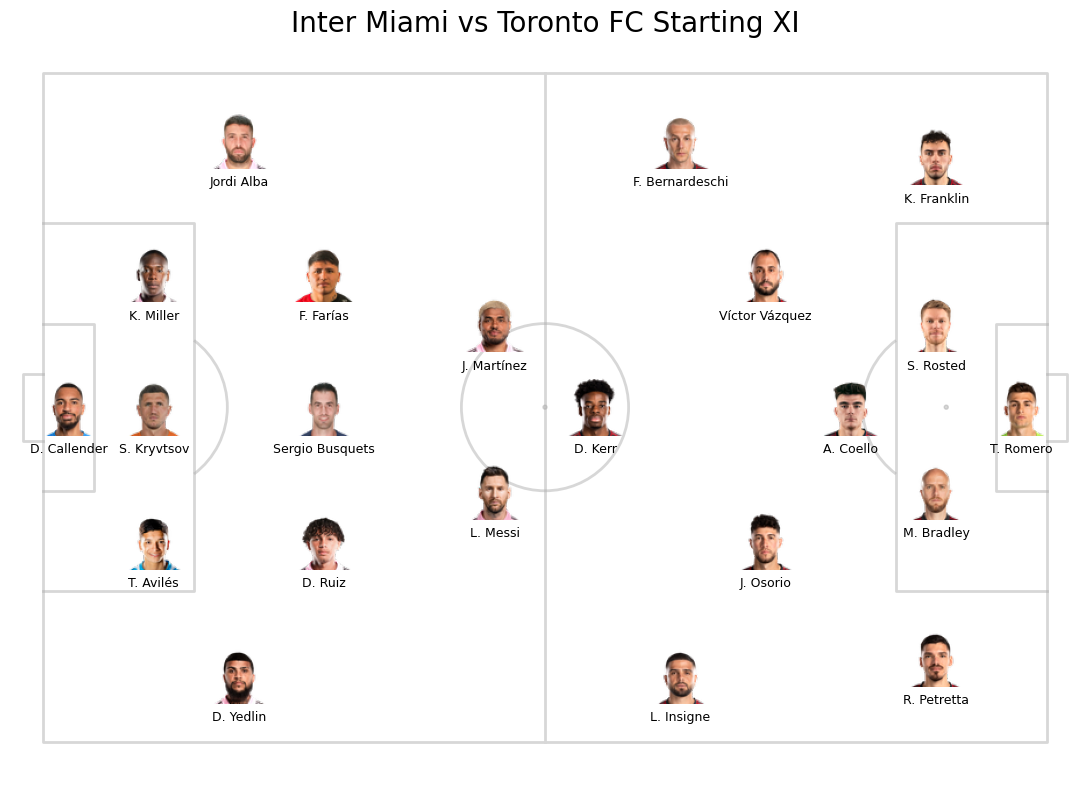

In [32]:
plot_formation(starting_xi, with_images=True, vertical=False)

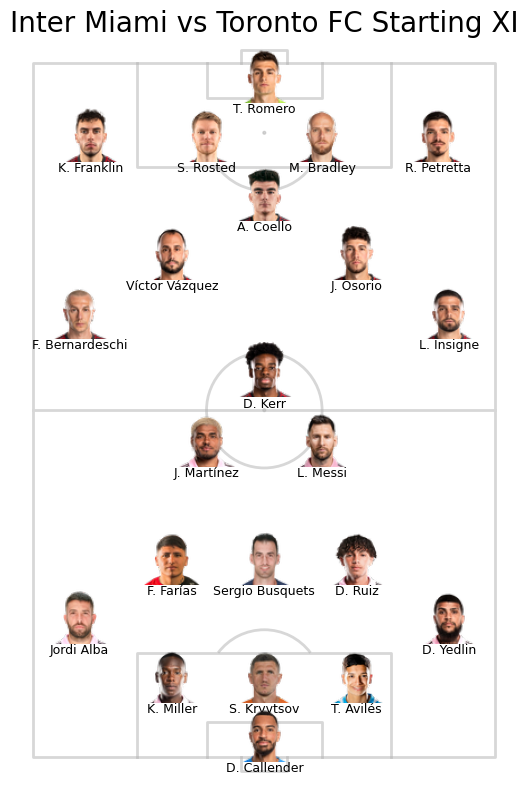

In [33]:
plot_formation(starting_xi, with_images=True, vertical=True)

### Game statistics

#### Generic statistics functionality

In [34]:
def round_metrics(df, columns=None):
    if columns is None:
        columns = ['xG', 'Pass Accuracy', 'Dribble Success Rate', 'Non-Penalty xG', 'xAG']
        
    for col in df.columns:
        if col not in columns:
            df[col] = df[col].round().astype(int)
        else:
            df[col] = df[col].round(2)
    
    return df

# Calculating the distance from start to finish towards the goal
def distance_covered_to_goal(x, y, end_x, end_y):
    dist_x = end_x - x
    dist_y = (abs(y - 40)) - (abs(end_y - 40))
    return dist_x + dist_y

def is_in_penalty_area(x, y):
    return x >= 102 and 18 <= y <= 62
    
def calculate_progressive_carries(player_data):
    carries = player_data[player_data['type_name'] == 'Carry']
    progressive_carries = 0
    
    for _, carry in carries.iterrows():
        if is_in_penalty_area(carry['end_x'], carry['end_y']) or (
            carry['end_x'] >= 60 and distance_covered_to_goal(carry['x'], carry['y'], carry['end_x'], carry['end_y']) >= 10
        ):
            progressive_carries += 1
        
    return progressive_carries

def calculate_progressive_passes(player_data):
    successful_passes = player_data[(player_data['type_name'] == 'Pass') & (player_data['outcome_name'].isnull())]
    progressive_passes = 0

    for _, row in successful_passes.iterrows():
        if is_in_penalty_area(row['end_x'], row['end_y']) or (
            row['x'] >= 48 and distance_covered_to_goal(row['x'], row['y'], row['end_x'], row['end_y']) >= 10
        ):
            progressive_passes += 1
    return progressive_passes

def calculate_xAG(events_df, passes):
    xAG_total = 0
    for _, key_pass in passes.iterrows():
        assisted_shot_xG = events_df[events_df['id'] == key_pass['pass_assisted_shot_id']]['shot_statsbomb_xg'].sum()
        xAG_total += assisted_shot_xG
    return xAG_total

In [35]:
def calculate_shot_metrics(data):
    penalties = data[data['play_pattern_name'] == 'Penalty']
    non_penalty_shots = data[data['play_pattern_name'] != 'Penalty']
    return {
        'Goals': len(data[data['outcome_name'] == 'Goal']),
        'Goal Attempts': len(data),
        'Shots on Goal': len(data[data['outcome_name'].isin(['Goal', 'Saved', 'Post'])]),
        'Shots off Goal': len(data[data['outcome_name'] == 'Off T']),
        'Blocked Shots': len(data[data['outcome_name'] == 'Blocked']),
        'xG': data['shot_statsbomb_xg'].sum(),
        'Non-Penalty xG': non_penalty_shots['shot_statsbomb_xg'].sum(),
        'Penalty Kicks Made': len(penalties[penalties['outcome_name'] == 'Goal']), # TODO !!! check the value with a match that had a penalty kick
        'Penalty Kicks Attempted': len(penalties) # TODO !!! check the value with a match that had a penalty kick
    }

def calculate_passing_metrics(data):
    total_passes = len(data)
    successful_passes = len(data[data['outcome_name'].isnull()])
    key_passes = data[data['pass_shot_assist'].notnull()]
    return {
        'Total Passes': total_passes,
        'Successful Passes': successful_passes,
        'Key Passes': len(data[data['pass_shot_assist'] == True]),
        'Passes into Penalty Area': len(data[data.apply(lambda x: is_in_penalty_area(x['end_x'], x['end_y']), axis=1)]),
        'Short Passes': len(data[data['pass_length'] < 10]),
        'Long Passes': len(data[data['pass_length'] > 30]),
        'Pass Accuracy': (successful_passes / total_passes) * 100 if total_passes > 0 else 0
    }

def calculate_dribbling_metrics(data):
    total_dribbles = len(data)
    successful_dribbles = len(data[data['outcome_name'] == 'Complete'])
    return {
        'Total Dribbles': total_dribbles,
        'Successful Dribbles': successful_dribbles,
        'Dribble Success Rate': (successful_dribbles / total_dribbles) * 100 if total_dribbles > 0 else 0
    }

def calculate_progressive_metrics(data):
    return {
        'Progressive Carries': calculate_progressive_carries(data),
        'Progressive Passes': calculate_progressive_passes(data)
    }

def calculate_defensive_metrics(data):
    tackles = data[(data['type_name'] == 'Duel') & (data['sub_type_name'] == 'Tackle')]
    return {
        'Tackles': len(tackles),
        'Tackles Won': len(tackles[tackles['outcome_name'].isin(['Won', 'Success In Play', 'Success Out'])]),
        'Tackles Lost': len(tackles[tackles['outcome_name'].isin(['Lost Out', 'Lost In Play'])]),
        'Interceptions': len(data[data['type_name'] == 'Interception']),
        'Clearances': len(data[data['type_name'] == 'Clearance']),
        'Recoveries': len(data[data['type_name'] == 'Ball Recovery']),
        'Blocks': len(data[(data['type_name'] == 'Block') | (data['outcome_name'] == 'Blocked')]),
        'Aerial Duels Won': len(data[data['aerial_won'] == True]),
        'Aerial Duels Lost': len(data[data['sub_type_name'] == "Aerial Lost"])
    }

def calculate_disciplinary_metrics(data):
    return {
        'Fouls Committed': len(data[data['type_name'] == 'Foul Committed']),
        'Fouls Won': len(data[data['type_name'] == 'Foul Won']),
        'Yellow Cards': len(data[data['type_name'] == 'Yellow Card']),
        'Red Cards': len(data[data['type_name'] == 'Red Card'])
    }

#### Calculating team statistics

In [36]:
# Specific metrics
def calculate_metrics(events_df, team, event_type, condition=None, outcome_condition=None):
    team_data = events_df[events_df['team_name'] == team]
    if outcome_condition:
        filtered_data = team_data[(team_data['type_name'] == event_type) & (team_data[condition].isin(outcome_condition))]
    else:
        filtered_data = team_data[team_data['type_name'] == event_type]
    return len(filtered_data)

# Initialize team metrics
def initialize_team_metrics(teams):
    return {team: {'Possession': 0, 'Goals': 0, 'xG': 0, 'Non-Penalty xG': 0, 'Goal Attempts': 0, 'Shots on Goal': 0, 'Shots off Goal': 0,
                   'Blocked Shots': 0, 'Penalty Kicks Made': 0, 'Penalty Kicks Attempted': 0, 'Free Kicks': 0, 'Corner Kicks': 0,
                   'Total Passes': 0, 'Successful Passes': 0, 'Pass Accuracy': 0, 'Key Passes': 0, 'Short Passes': 0, 'Long Passes': 0, 'Passes into Penalty Area': 0,  
                   'Total Dribbles': 0, 'Successful Dribbles': 0, 'Dribble Success Rate': 0, 'Progressive Carries': 0, 'Progressive Passes': 0, 'Tackles': 0, 
                   'Tackles Won': 0, 'Tackles Lost': 0, 'Interceptions': 0, 'Recoveries': 0, 'Clearances': 0, 'Blocks': 0, 'Aerial Duels Won': 0, 'Aerial Duels Lost': 0, 
                   'Fouls Committed': 0, 'Fouls Won': 0, 'Yellow Cards': 0, 'Red Cards': 0} 
            for team in teams}

def calculate_team_metrics(events_df):
    teams = events_df['team_name'].unique()
    metrics = initialize_team_metrics(teams)

    possession_data = events_df.groupby(['possession_team_name', 'possession']).agg({'duration': 'sum'}).reset_index()
    total_possession_duration = possession_data['duration'].sum()

    for team in teams:
        team_possession_duration = possession_data[possession_data['possession_team_name'] == team]['duration'].sum()
        metrics[team]['Possession'] = (team_possession_duration / total_possession_duration) * 100
        team_data = events_df[events_df['team_name'] == team]

        # Goal statistics
        shot_metrics = calculate_shot_metrics(team_data[team_data['type_name'] == 'Shot'])
        metrics[team].update(shot_metrics)

        # Set piece statistics
        metrics[team]['Free Kicks'] = calculate_metrics(events_df, team, 'Pass', 'play_pattern_name', ['From Free Kick'])
        metrics[team]['Corner Kicks'] = calculate_metrics(events_df, team, 'Pass', 'play_pattern_name', ['From Corner'])

        # Pass statistics
        passing_metrics = calculate_passing_metrics(team_data[team_data['type_name'] == 'Pass'])
        metrics[team].update(passing_metrics)

        # Dribble statistics
        dribbling_metrics = calculate_dribbling_metrics(team_data[team_data['type_name'] == 'Dribble'])
        metrics[team].update(dribbling_metrics)

        # Progressive statistics
        progressive_metrics = calculate_progressive_metrics(team_data)
        metrics[team].update(progressive_metrics)

        # Defensive statistics
        defensive_metrics = calculate_defensive_metrics(team_data)
        metrics[team].update(defensive_metrics)

        # Foul statistics
        foul_metrics = calculate_disciplinary_metrics(team_data)
        metrics[team].update(foul_metrics)

    return round_metrics(pd.DataFrame(metrics).T)

In [37]:
team_metrics_df = calculate_team_metrics(events_df)
team_metrics_df

,Possession,Goals,xG,Non-Penalty xG,Goal Attempts,Shots on Goal,Shots off Goal,Blocked Shots,Penalty Kicks Made,Penalty Kicks Attempted,Free Kicks,Corner Kicks,Total Passes,Successful Passes,Pass Accuracy,Key Passes,Short Passes,Long Passes,Passes into Penalty Area,Total Dribbles,Successful Dribbles,Dribble Success Rate,Progressive Carries,Progressive Passes,Tackles,Tackles Won,Tackles Lost,Interceptions,Recoveries,Clearances,Blocks,Aerial Duels Won,Aerial Duels Lost,Fouls Committed,Fouls Won,Yellow Cards,Red Cards
Inter Miami,58,4,1.03,1.03,13,5,5,3,0,0,49,12,719,641,89.15,6,140,79,43,13,8,61.54,64,115,27,20,7,10,50,10,15,1,4,20,7,0,0
Toronto FC,42,0,0.78,0.78,8,4,2,2,0,0,107,13,485,423,87.22,5,88,61,19,22,10,45.45,38,49,14,10,4,16,42,10,17,4,1,7,18,0,0


#### Calculating player statistics

In [38]:
def calculate_player_metrics(events_df, tactics):
    players = events_df[events_df['player_name'].notna()]['player_name'].unique()
    player_metrics = {player: {
        'Matches Played': 0, 'Starts': 0, 'Minutes Played': 0, 'Goals': 0, 'Assists': 0, 'xG': 0, 'Non-Penalty xG': 0, 'xAG': 0, 'Goal Attempts': 0, 'Shots on Goal': 0, 'Shots off Goal': 0,  
        'Blocked Shots': 0, 'Penalty Kicks Made': 0, 'Penalty Kicks Attempted': 0, 'Total Passes': 0, 'Successful Passes': 0, 'Pass Accuracy': 0, 'Key Passes': 0, 'Short Passes': 0, 
        'Long Passes': 0, 'Passes into Penalty Area': 0, 'Progressive Passes Received': 0, 'Total Dribbles': 0, 'Successful Dribbles': 0, 'Dribble Success Rate': 0, 
        'Progressive Carries': 0, 'Progressive Passes': 0, 'Touches': 0, 'Touches in Opponent’s Box': 0, 'Tackles': 0, 'Tackles Won': 0, 'Tackles Lost': 0, 'Interceptions': 0, 'Recoveries': 0, 
        'Clearances': 0, 'Blocks': 0, 'Aerial Duels Won': 0, 'Aerial Duels Lost': 0, 'Fouls Committed': 0, 'Fouls Won': 0, 'Yellow Cards': 0, 'Red Cards': 0,
    } for player in players}

    # Half durations
    events_df['timestamp'] = pd.to_timedelta(events_df['timestamp'].astype(str))
    half_durations = events_df.groupby('period')['timestamp'].max().dt.total_seconds() / 60
    first_half_duration = half_durations.get(1, 0)
    second_half_duration = half_durations.get(2, 0)

    starting_xi_event = events_df.loc[events_df['type_name'] == 'Starting XI', ['id', 'tactics_formation']]
    starting_xi = tactics.merge(starting_xi_event, on='id')['player_name'].values

    for player in players:
        player_data = events_df[events_df['player_name'] == player]

        player_metrics[player]['Matches Played'] = 1
        # Minutes played
        if player in starting_xi:
            player_metrics[player]['Starts'] = 1
            player_metrics[player]['Minutes Played'] = calculate_minutes_played(player_data, first_half_duration, second_half_duration)
        else:
            substitutions_on = events_df[events_df['substitution_replacement_name'] == player]
            if not substitutions_on.empty:
                start_minute = substitutions_on['timestamp'].min().total_seconds() / 60
                if substitutions_on['period'].iloc[0] == 2:
                    start_minute = start_minute + first_half_duration
                player_metrics[player]['Minutes Played'] = calculate_minutes_played(player_data, first_half_duration, second_half_duration, start_minute=start_minute)

        # Statistics
        calculate_individual_metrics(player_metrics, player, player_data, events_df)

    return round_metrics(pd.DataFrame(player_metrics).T)

def calculate_minutes_played(player_data, first_half_duration, second_half_duration, start_minute=0):
    substitutions_off = player_data[player_data['type_name'] == 'Substitution']
    if not substitutions_off.empty:
        end_timestamp = substitutions_off['timestamp'].min()
        end_minute = end_timestamp.total_seconds() / 60
        duration = end_minute
        if substitutions_off['period'].iloc[0] == 2:
            duration = duration + first_half_duration
        return duration - start_minute
    return first_half_duration + second_half_duration - start_minute
 
def calculate_individual_metrics(player_metrics, player, player_data, events_df):
    # Shot statistics
    shots = player_data[player_data['type_name'] == 'Shot']
    shot_metrics = calculate_shot_metrics(shots)
    player_metrics[player].update(shot_metrics)
    
    # Pass statistics
    passes = player_data[player_data['type_name'] == 'Pass']
    passing_metrics = calculate_passing_metrics(passes)
    player_metrics[player].update(passing_metrics)
    player_metrics[player]['Assists'] = len(passes[passes['pass_goal_assist'] == True])
    player_metrics[player]['xAG'] = calculate_xAG(events_df, passes)

    # Dribble statistics
    dribbles = player_data[player_data['type_name'] == 'Dribble']
    dribbling_metrics = calculate_dribbling_metrics(dribbles)
    player_metrics[player].update(dribbling_metrics)

    # Progressive statistics
    progressive_metrics = calculate_progressive_metrics(player_data)
    player_metrics[player]['Progressive Passes Received'] = calculate_progressive_passes(events_df[events_df['pass_recipient_name'] == player])
    player_metrics[player].update(progressive_metrics)

    touches = player_data[
        (player_data['type_name'].isin(['Carry', 'Shot', 'Clearance', 'Foul Won'])) |
        ((player_data['type_name'] != 'Dribble') & (player_data['outcome_name'] == 'Complete')) |
        ((player_data['type_name'] == 'Pass') & (player_data['outcome_name'].isnull())) |
        ((player_data['type_name'] == 'Ball Receipt*') & (player_data['outcome_name'].isnull()))
    ]
    player_metrics[player]['Touches'] = len(touches) 
    player_metrics[player]['Touches in Opponent’s Box'] = len(touches[touches.apply(lambda x: is_in_penalty_area(x['x'], x['y']), axis=1)])
    
    # Defensive statistics
    defensive_metrics = calculate_defensive_metrics(player_data)
    player_metrics[player].update(defensive_metrics)
    
    # Foul statistics
    foul_metrics = calculate_disciplinary_metrics(player_data)
    player_metrics[player].update(foul_metrics)

In [39]:
player_metrics_df = calculate_player_metrics(events_df, tactics)
player_metrics_df.sort_values('Minutes Played')

,Matches Played,Starts,Minutes Played,Goals,Assists,xG,Non-Penalty xG,xAG,Goal Attempts,Shots on Goal,Shots off Goal,Blocked Shots,Penalty Kicks Made,Penalty Kicks Attempted,Total Passes,Successful Passes,Pass Accuracy,Key Passes,Short Passes,Long Passes,Passes into Penalty Area,Progressive Passes Received,Total Dribbles,Successful Dribbles,Dribble Success Rate,Progressive Carries,Progressive Passes,Touches,Touches in Opponent’s Box,Tackles,Tackles Won,Tackles Lost,Interceptions,Recoveries,Clearances,Blocks,Aerial Duels Won,Aerial Duels Lost,Fouls Committed,Fouls Won,Yellow Cards,Red Cards
Víctor Vázquez Solsona,1,1,12,0,0,0.00,0.00,0.00,0,0,0,0,0,0,8,8,100.00,0,2,0,0,0,0,0,0.00,0,0,13,0,0,0,0,0,0,0,1,0,0,0,0,0,0
Brandon Iván Servania,1,0,14,0,0,0.00,0.00,0.00,0,0,0,0,0,0,4,4,100.00,0,1,0,0,0,0,0,0.00,1,0,12,0,0,0,0,1,0,0,0,0,0,0,1,0,0
Latif Blessing,1,0,24,0,0,0.00,0.00,0.00,0,0,0,0,0,0,11,10,90.91,0,1,0,0,0,0,0,0.00,0,0,23,0,1,0,1,1,0,0,0,1,0,0,1,0,0
Charles Kwabena Sapong,1,0,24,0,0,0.00,0.00,0.00,0,0,0,0,0,0,3,3,100.00,0,1,0,0,2,0,0,0.00,0,0,9,0,0,0,0,1,0,1,1,1,0,0,1,0,0
Themi Antonoglou,1,0,25,0,0,0.00,0.00,0.00,0,0,0,0,0,0,8,6,75.00,0,0,3,0,0,0,0,0.00,0,1,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Leonardo Campana Romero,1,0,28,0,0,0.06,0.06,0.00,1,0,0,1,0,0,17,16,94.12,0,3,1,0,6,1,1,100.00,3,0,32,5,0,0,0,0,2,0,1,0,1,0,0,0,0
Dixon Jair Arroyo Espinoza,1,0,28,0,0,0.00,0.00,0.00,0,0,0,0,0,0,24,22,91.67,0,6,3,1,2,0,0,0.00,1,5,46,1,1,1,0,0,2,1,0,0,0,1,0,0,0
Benjamin Cremaschi,1,0,28,1,0,0.14,0.14,0.00,1,1,0,0,0,0,27,24,88.89,0,8,1,1,8,1,1,100.00,4,4,51,1,0,0,0,0,1,0,0,0,1,1,1,0,0
Jordi Alba Ramos,1,1,34,0,0,0.00,0.00,0.13,0,0,0,0,0,0,38,28,73.68,2,8,5,5,6,0,0,0.00,3,10,55,1,0,0,0,1,0,1,0,0,0,0,0,0,0
Lionel Andrés Messi Cuccittini,1,1,37,0,0,0.29,0.29,0.00,3,1,1,1,0,0,20,14,70.00,0,5,2,2,8,1,1,100.00,6,3,37,5,0,0,0,0,3,0,1,0,0,0,0,0,0


### Export of each generated dataFrame

In [41]:
def export_match_data(match_id, events_df, starting_xi_df, team_metrics_df, player_metrics_df, base_folder="datasets"):
    match_data_folder = os.path.join(base_folder, f"match_{match_id}")
    os.makedirs(match_data_folder, exist_ok=True)
    
    events_path   = os.path.join(match_data_folder, "events.csv")
    starting_xi_path = os.path.join(match_data_folder, "starting_xi.csv")
    team_metrics_path = os.path.join(match_data_folder, "team_metrics.csv")
    player_metrics_path = os.path.join(match_data_folder, "player_metrics.csv")
    
    events_df.to_csv(events_path, index=False)
    starting_xi_df.to_csv(starting_xi_path, index=False)
    team_metrics_df.to_csv(team_metrics_path, index=False)
    player_metrics_df.to_csv(player_metrics_path, index=False)
    
    print(f"Data exported:\n  {events_path}\n  {starting_xi_path}\n  {team_metrics_path}\n  {player_metrics_path}")

In [42]:
export_match_data(match_id, events_df, starting_xi, team_metrics_df, player_metrics_df)

Data exported:
  datasets\match_3877115\events.csv
  datasets\match_3877115\starting_xi.csv
  datasets\match_3877115\team_metrics.csv
  datasets\match_3877115\player_metrics.csv
